In [1]:
%reload_ext autoreload
%autoreload 2

from torch_snippets import *
from torch_snippets.trainer.capsule import Capsule, train, validate, predict
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

data = load_iris()
X, y = data.data, data.target
X_trn, X_val, y_trn, y_val = train_test_split(X, y, random_state=42)

In [3]:
from torch.utils.data import TensorDataset

trn_ds = TensorDataset(*[torch.Tensor(i) for i in [X_trn, y_trn]])
trn_dl = DataLoader(trn_ds, batch_size=32)

val_ds = TensorDataset(*[torch.Tensor(i) for i in [X_val, y_val]])
val_dl = DataLoader(val_ds, batch_size=32)

inspect(next(iter(val_dl)))

list of 2 items
	Tensor	Shape: torch.Size([32, 4])	Min: 0.100	Max: 7.900	Mean: 3.488	dtype: torch.float32 @ cpu
	Tensor	Shape: torch.Size([32])	Min: 0.000	Max: 2.000	Mean: 0.969	dtype: torch.float32 @ cpu


In [6]:
from torch_snippets.trainer.capsule import Capsule, train, validate, predict

class IrisModel(Capsule):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
        nn.BatchNorm1d(4),
        nn.Linear(4, 16),
        nn.Dropout(0.2),
        nn.BatchNorm1d(16),
        nn.ReLU(inplace=True),
        nn.Linear(16, 8),
        nn.Dropout(0.2),
        nn.BatchNorm1d(8),
        nn.ReLU(inplace=True),
        nn.Linear(8, 3),
    )
    self.loss_fn = nn.CrossEntropyLoss()
    self.optimizer = optim.Adam(self.parameters())

  def forward(self, x):
    return self.model(x)

  @train
  def train_batch(self, batch):
    x, y = batch
    _y = self.forward(x)
    loss = self.loss_fn(_y, y.long())
    return {'loss': loss}

  @validate
  def validate_batch(self, batch=None, dl=None):
    if dl is not None:
      output = []
      for batch in dl:
        output.extend(self.predict(batch=batch)['val_acc'])
      return np.mean(output)
    x, y = batch
    _y = self.forward(x)
    loss = self.loss_fn(_y, y.long())
    acc = (y == _y.max(-1)[1]).float().mean()
    return {'val_loss': loss, 'val_acc': acc}


  @predict
  def predict(self, batch=None, dl=None):
    if dl is not None:
      output = []
      for batch in dl:
        output.extend(self.predict(batch=batch))
      return output
    x, y = batch
    _y = self.forward(x)
    o = _y.max(-1)[1].cpu().detach().numpy().tolist()
    return o

model = IrisModel()
model.device = 'cpu'

EPOCH: 1.000	loss: 0.998	val_loss: 1.117	val_acc: 0.344	(0.02s - 1.96s remaining)
EPOCH: 50.000	loss: 0.437	val_loss: 0.379	val_acc: 1.000	(0.63s - 0.63s remaining)
EPOCH: 100.000	loss: 0.250	val_loss: 0.143	val_acc: 0.984	(1.34s - 0.00s remaining)


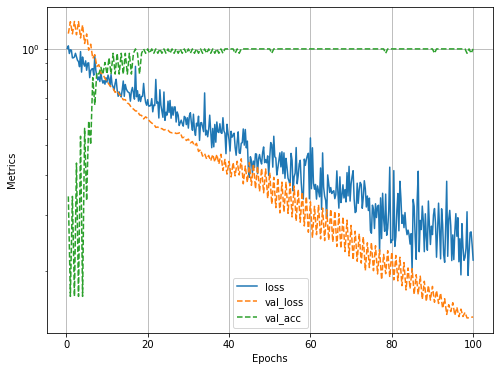

In [7]:
model.fit(trn_dl, val_dl, num_epochs=100, print_total=2, device='cpu')